# Example: SBO for H$_2$ VQE

Notebook modeled after https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html.

NOTE: This notebook requires PySCF. See https://pyscf.org/install.html for details.

In [1]:
import sbovqaopt

import matplotlib.pyplot as plt
import numpy as np

from qiskit import Aer
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import GroundStateEigensolver, MinimumEigensolverFactory, VQEUCCFactory
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

In [2]:
def ideal_backend(nshots):
    # construct an ideal simulator with only quantum shot noise
    return QuantumInstance(
        backend=Aer.get_backend("qasm_simulator"), 
        shots=nshots)

distances = np.arange(0.2, 1.5, 0.05)   # true ground state ~0.735
exact_energies = {}
vqe_sbo_energies = {}
vqe_spsa_energies = {}

nshots = 100
repetition_count = 5

for distance in distances:
    exact_energies[distance] = []
    vqe_sbo_energies[distance] = []
    vqe_spsa_energies[distance] = []
        
    molecule = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, distance]]], charge=0, multiplicity=1
    )
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
    )

    es_problem = ElectronicStructureProblem(driver)
    qubit_converter = QubitConverter(JordanWignerMapper())
    
    def solve(solver):
        calc = GroundStateEigensolver(qubit_converter, solver)
        res = calc.solve(es_problem)
        es_result = es_problem.interpret(res.raw_result)
        return es_result.total_energies[0]        
    
    for _ in range(repetition_count):
        # Exact solver
        numpy_solver = NumPyMinimumEigensolver()
        exact_energies[distance].append(solve(numpy_solver))

        # VQE with SBO optimizer on ideal simulator, num function evals=20
        sbo_optimizer = sbovqaopt.optimizer.Optimizer(
            maxiter=4,
            patch_size=0.15,
            npoints_per_patch=4,
            nfev_final_avg=4
        )
        vqe_solver = VQEUCCFactory(
            quantum_instance=ideal_backend(nshots=nshots),
            optimizer=sbo_optimizer
        )
        vqe_sbo_energies[distance].append(solve(vqe_solver))

        # VQE with SPSA optimizer on ideal simulator, num function evals=20
        spsa_optimizer = SPSA(maxiter=10)
        vqe_solver = VQEUCCFactory(
            quantum_instance=ideal_backend(nshots=nshots),
            optimizer=spsa_optimizer
        )
        vqe_spsa_energies[distance].append(solve(vqe_solver))
    
    print(f"Distance: {distance:.3f}, " + 
          f"SBO: {np.mean(vqe_sbo_energies[distance]):.6f}, " + 
          f"SPSA: {np.mean(vqe_spsa_energies[distance]):.6f}, " + 
          f"Exact Result: {np.mean(exact_energies[distance]):.6f}")

Distance: 0.200, SBO: 0.187946, SPSA: 2.014428, Exact Result: 0.157482
Distance: 0.250, SBO: -0.297275, SPSA: 1.447413, Exact Result: -0.312270
Distance: 0.300, SBO: -0.596331, SPSA: 0.770110, Exact Result: -0.601804
Distance: 0.350, SBO: -0.764369, SPSA: 0.801700, Exact Result: -0.789269
Distance: 0.400, SBO: -0.893476, SPSA: 0.299017, Exact Result: -0.914150
Distance: 0.450, SBO: -0.983395, SPSA: 0.276021, Exact Result: -0.998416
Distance: 0.500, SBO: -1.035785, SPSA: -0.140821, Exact Result: -1.055160
Distance: 0.550, SBO: -1.079132, SPSA: -0.089214, Exact Result: -1.092630
Distance: 0.600, SBO: -1.119878, SPSA: -0.266154, Exact Result: -1.116286
Distance: 0.650, SBO: -1.131653, SPSA: -0.237041, Exact Result: -1.129905
Distance: 0.700, SBO: -1.115995, SPSA: -0.503991, Exact Result: -1.136189
Distance: 0.750, SBO: -1.130520, SPSA: -0.724075, Exact Result: -1.137117
Distance: 0.800, SBO: -1.125553, SPSA: -0.532140, Exact Result: -1.134148
Distance: 0.850, SBO: -1.116461, SPSA: -0.7119

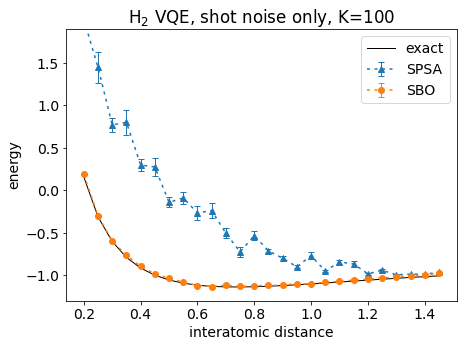

In [3]:
plt.figure(figsize=(7, 5))
plt.rcParams['font.size'] = 14

def plot_energies(energies, label, marker, color):
    y = np.mean(list(energies.values()), axis=1)
    stds = np.std(list(energies.values()), axis=1)
    yerr = np.divide(stds, np.sqrt(len(stds)))
    linestyle_dotted = (0, (2, 3))
    plt.errorbar(
        distances, y, yerr, elinewidth=1.0, capsize=3.0,
        marker=marker, linestyle=linestyle_dotted,
        label=label, color=color)

plt.plot(distances, np.mean(list(exact_energies.values()), axis=1), 'k-', linewidth=1, label='exact')
plot_energies(vqe_spsa_energies, f'SPSA', marker='^', color='C0')
plot_energies(vqe_sbo_energies, f'SBO', marker='o', color='C1')

plt.legend()
plt.xlabel('interatomic distance')
plt.ylabel('energy')
plt.ylim(-1.3, 1.9)
plt.title(r"H$_2$ VQE, shot noise only, K=100")
plt.show()